In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from itertools import combinations
from scipy.spatial import cKDTree
from IPython.display import display
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['grey', 'red'])
from sklearn.cluster import DBSCAN
import cv2
import networkx as nx
from collections import Counter
import random

DATA_PATH = "/home/kartik/layout-analysis/stress-test-data"
SAMPLE_SIZE = 6  #number of pages to process
GRAPH_DATA_PATH = "/home/kartik/layout-analysis/graph-data/"



In [2]:

NUM_NEIGHBOURS = 8
norm_ratio_threshold = 2  # Allows a max ratio of 1.5 between the norms
cos_similarity_less_than = -0.8
# we assume that character spacing is less than line spacing 


%matplotlib widget


In [3]:


def cluster_with_single_majority(to_cluster, eps=3, min_samples=2):
    """
    Clusters data, identifying only one majority cluster and marking all other points as outliers.

    Args:
        to_cluster: List of data points to cluster.
        eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples: The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        NumPy array of labels, where the majority cluster is labeled 0, and all other points are labeled -1.
    """
    to_cluster_array = np.array(to_cluster)

    if len(to_cluster_array) == 0:
      return np.array([])

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(to_cluster_array)

    # Count the occurrences of each label
    label_counts = Counter(labels)

    # Find the majority cluster label (excluding -1 outliers)
    majority_label = None
    max_count = 0
    for label, count in label_counts.items():
        if label != -1 and count > max_count:
            majority_label = label
            max_count = count

    # Create a new label array where the majority cluster is 0 and all others are -1
    new_labels = np.full(len(labels), -1)  # Initialize all as outliers

    if majority_label is not None:
        new_labels[labels == majority_label] = 0  # Assign 0 to the majority cluster

    return new_labels

In [4]:
def convert_to_graph(to_plot, points):
    # Create an empty graph
    G = nx.Graph()
    
    # Add all points as nodes with their coordinates as features
    for i, point in enumerate(points):
        G.add_node(i, pos=point)
    
    # Add edges from to_plot, avoiding duplicates (NetworkX handles this automatically)
    for center, neighbor1, neighbor2 in to_plot:
        G.add_edge(center, neighbor1)
        G.add_edge(center, neighbor2)
    
    # Create adjacency matrix
    adj_matrix = nx.to_numpy_array(G)
    
    # Create feature matrix (each row contains the x,y coordinates of a point)
    feature_matrix = np.array([G.nodes[i]['pos'] for i in range(len(points))])
    
    return G, adj_matrix, feature_matrix

In [5]:
pg_no = 1

#TODO
# better clustering (more features)
# what is that horizontal vertical mystery of the stress test page..

Processing file: /home/kartik/layout-analysis/stress-test-data/11.txt


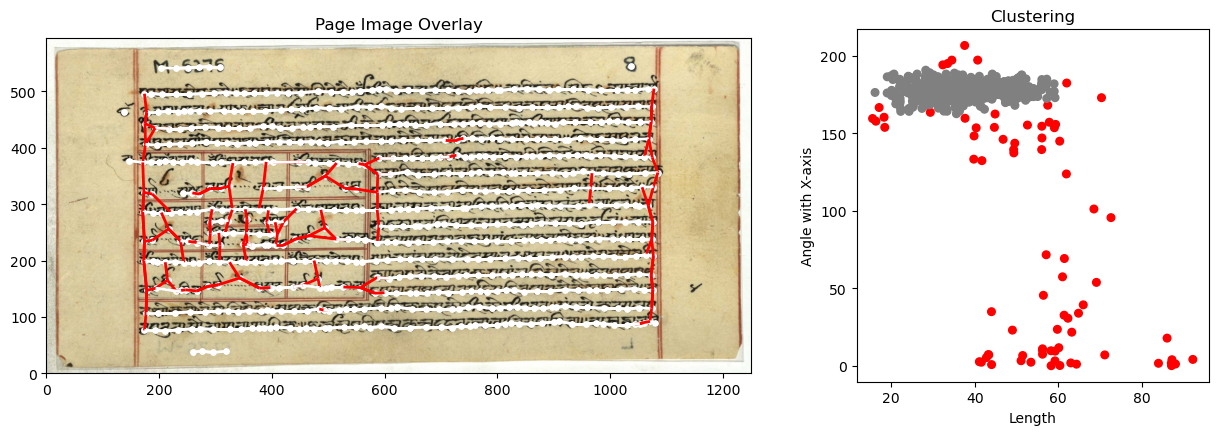

Graph created with 680 nodes and 724 edges
Original connections: 1334 (each in to_plot creates 2 connections)
Unique connections after removing duplicates: 724
Links (1): 612, No-links (0): 112


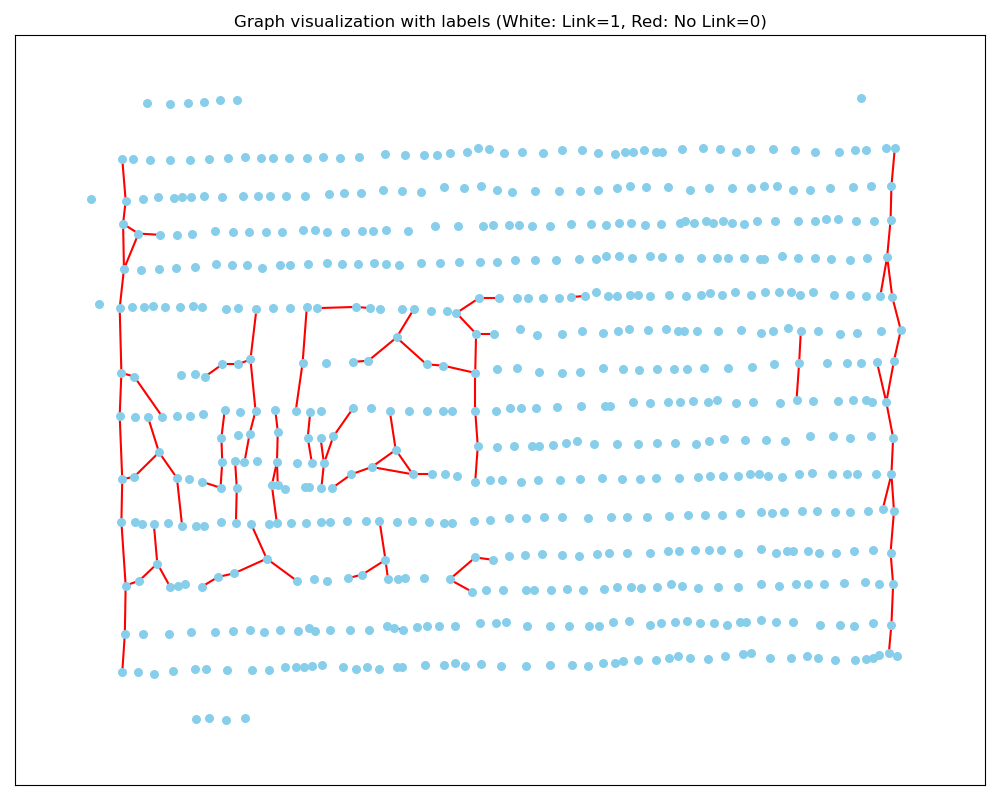

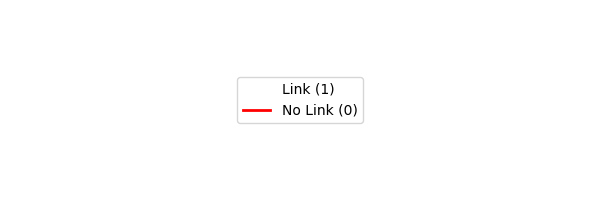

Number of connected components: 5

Link Prediction Dataset Statistics:
  - Total edges: 724
  - Positive examples (links): 612 (84.5%)
  - Negative examples (no-links): 112 (15.5%)
  - Training set: 579 edges
  - Test set: 145 edges


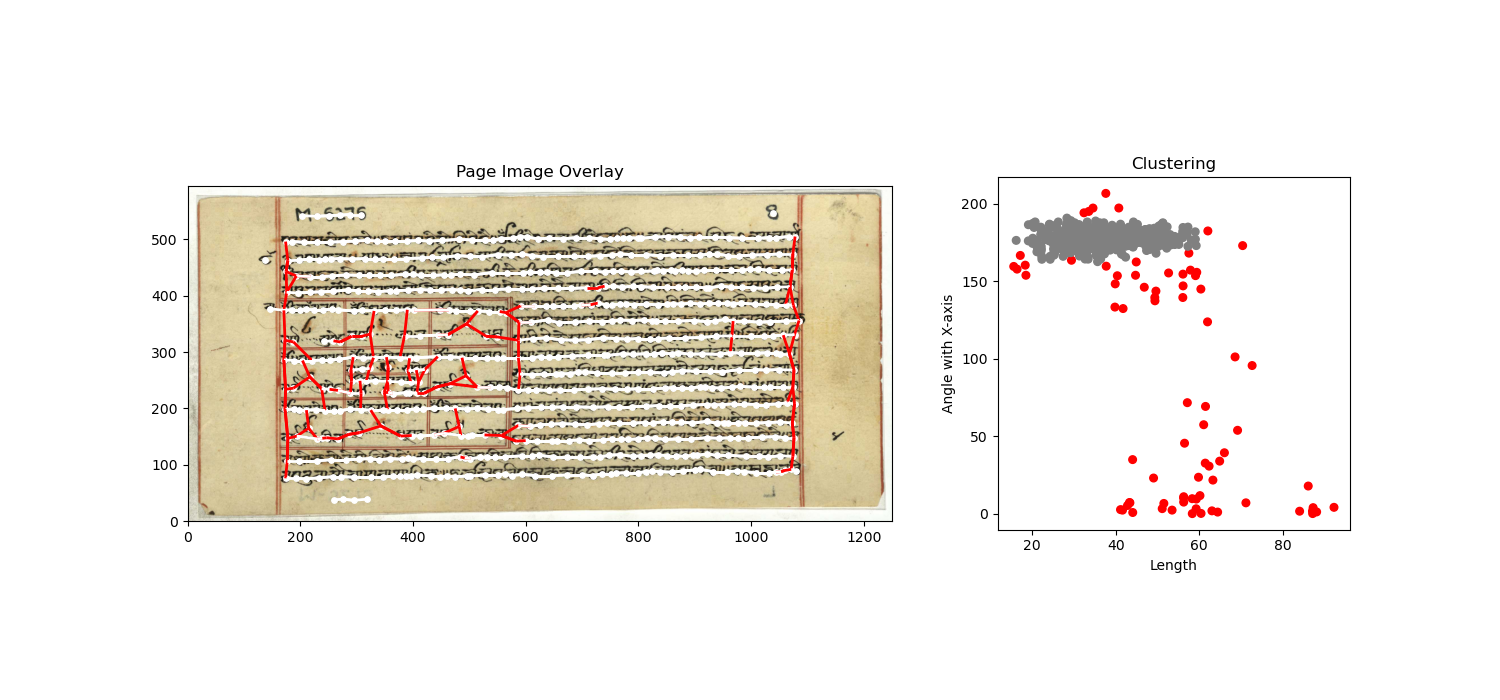

In [16]:
# Get unique prefixes efficiently without sorting everything
for entry in os.scandir(DATA_PATH):
    # if entry.is_file() and entry.name.endswith(f'{pg_no}.txt'):
    if entry.is_file() and entry.name == f'{pg_no}.txt':

        bg_img = plt.imread(DATA_PATH+f"/{pg_no}.jpg")  # Replace with your image path
        bg_img = cv2.resize(bg_img, (bg_img.shape[1] // 2, bg_img.shape[0] // 2))
        height, width = bg_img.shape[:2]

        points_file = entry.path
        print(f"Processing file: {points_file}")
        points = np.loadtxt(points_file)
        
        # Build a KD-tree for fast neighbor lookup
        tree = cKDTree(points)
        _, indices = tree.query(points, k=NUM_NEIGHBOURS)
        
        segments = []
        seg_colors = [] 

        to_cluster = []
        to_plot = []

        # Process nearest neighbors
        for current_point_index, nbr_indices in enumerate(indices):
            normalized_points = points[nbr_indices] - points[current_point_index]
            scaling_factor = np.max(np.abs(normalized_points))
            if scaling_factor == 0:
                scaling_factor = 1
            scaled_points = normalized_points / scaling_factor
            relative_neighbours = [(global_idx, sp, np)
                                   for global_idx, sp, np in zip(nbr_indices, scaled_points, normalized_points)]
            

            filtered_neighbours = []
            for _a, _b in combinations(relative_neighbours, 2):
                # calculate the angle between the two pair vectors
                if np.linalg.norm(_a[1]) * np.linalg.norm(_b[1]) == 0:
                    cos_similarity = 0.0
                else:
                    cos_similarity = np.dot(_a[1], _b[1]) / (np.linalg.norm(_a[1]) * np.linalg.norm(_b[1]))

                # calculate the non-normalized length of the pair
                norm1 = np.linalg.norm(_a[2])
                norm2 = np.linalg.norm(_b[2])
                total_length = norm1 + norm2

                # select pairs who have an angle of around 180 degrees between them
                if cos_similarity < cos_similarity_less_than:
                    filtered_neighbours.append((_a, _b, total_length, cos_similarity))

            if filtered_neighbours:
                # select the pair with the shortest total_length (sometimes, the 2nd shortest is the right answer)
                shortest_pair = min(filtered_neighbours, key=lambda x: x[2])

                _connection_1, _connection_2, total_length, cos_similarity = shortest_pair
                global_idx_connection_1 = _connection_1[0]
                global_idx_connection_2 = _connection_2[0]

                # calculate the angles made with the X-axis for clustering purpose
                theta_a = np.degrees(np.arctan2(_connection_1[2][1], _connection_1[2][0]))
                theta_b = np.degrees(np.arctan2(_connection_2[2][1], _connection_2[2][0]))
                theta = (theta_a,theta_b)
                
                to_plot.append((current_point_index, global_idx_connection_1, global_idx_connection_2))
                to_cluster.append((total_length, np.abs(theta[0]+theta[1]), )) # absolute value because we want 0, 180, -180 to be the same


        to_cluster_array = np.array(to_cluster)  # Convert list to NumPy array

        # Run DBSCAN (adjust eps and min_samples as needed)
        # dbscan = DBSCAN(eps=3, min_samples=2)  # Tune these parameters
        # labels = dbscan.fit_predict(to_cluster_array)
        labels = cluster_with_single_majority(to_cluster, eps=3, min_samples=2)
        colors = np.zeros(len(to_cluster))
        # Mark outliers (DBSCAN assigns -1 to outliers)
        colors[labels == -1] = 1
    
        # Adjust figure layout: large left panel for nearest neighbors, smaller right panel for scatter plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), 
                                       gridspec_kw={'width_ratios': [2, 1]})  # Left panel is twice the width
        #ax1.set_box_aspect(1)  # Keep the box aspect ratio equal for both axes
        ax2.set_box_aspect(1)  
        
        # Nearest neighbors plot (left)
        # Keep track of all segment connections and their colors for labels
        edge_labels = {}  # Dictionary to store (source, target): label
        
        for i, s in enumerate(to_plot):
            seg1 = (points[s[0]], points[s[1]])
            seg2 = (points[s[0]], points[s[2]])
            segments.extend([seg1, seg2])
            
            # Determine segment color (red = no link = 0, white = link = 1)
            segment_color = 'red' if colors[i] == 1 else 'white'
            seg_colors.extend([segment_color, segment_color])
            
            # Store edge labels for graph creation
            # 0 = no link (red), 1 = link (white)
            label_value = 0 if segment_color == 'red' else 1
            
            # Store labels for both edges
            edge_labels[(s[0], s[1])] = label_value
            edge_labels[(s[0], s[2])] = label_value

        ax1.imshow(bg_img, alpha=1, zorder=0, extent=[0, width, 0, height])
        ax1.set_xlim(0, width)
        ax1.set_ylim(0, height) 
        base_lc = mc.LineCollection(segments, linewidths=2, alpha=1, colors=seg_colors)
        ax1.add_collection(base_lc)
        ax1.scatter(points[:, 0], points[:, 1], c='white', s=15)
        ax1.set_title("Page Image Overlay")

        # Scatter plot (right)
        distances, cos_similarities = zip(*to_cluster) if to_cluster else ([], [])
        scatter = ax2.scatter(distances, cos_similarities, c=colors, cmap=cmap, s=30, alpha=1, picker=True)
        ax2.set_xlabel('Length')
        ax2.set_ylabel('Angle with X-axis')
        ax2.set_title('Clustering')

        # Interactive Highlighting
        highlighted_segments = [None]

        def on_pick(event):
            if event.artist != scatter:
                return
            if len(event.ind) == 0:
                return

            i = event.ind[0]
            s = to_plot[i]
            seg1 = (points[s[0]], points[s[1]])
            seg2 = (points[s[0]], points[s[2]])
            
            if highlighted_segments[0] is not None:
                highlighted_segments[0].remove()
                highlighted_segments[0] = None

            highlighted_segments[0] = mc.LineCollection([seg1, seg2], linewidths=6, colors='black')
            ax1.add_collection(highlighted_segments[0])
            fig.canvas.draw_idle()

        fig.canvas.mpl_connect('pick_event', on_pick)

        # Display the interactive figure (keeps multiple figures interactive)
        display(fig)

        # Create the graph and matrices
        G, adjacency_matrix, feature_matrix = convert_to_graph(to_plot, points)
        
        # Add edge labels to the graph
        for u, v in G.edges():
            # Check if this edge has a label
            if (u, v) in edge_labels:
                G[u][v]['label'] = edge_labels[(u, v)]
            elif (v, u) in edge_labels:
                # Handle undirected edges
                G[u][v]['label'] = edge_labels[(v, u)]
            else:
                # Default if not found (shouldn't happen)
                G[u][v]['label'] = -1
        
        # Create labeled adjacency matrix for link prediction
        num_nodes = len(G.nodes())
        labeled_adj_matrix = np.zeros((num_nodes, num_nodes))
        
        for u, v, data in G.edges(data=True):
            if 'label' in data:
                labeled_adj_matrix[u][v] = data['label']
                labeled_adj_matrix[v][u] = data['label']  # For undirected graph
        
        # Print some statistics about the graph
        print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        print(f"Original connections: {len(to_plot)*2} (each in to_plot creates 2 connections)")
        print(f"Unique connections after removing duplicates: {G.number_of_edges()}")
        
        # Count links (1) and no-links (0)
        link_count = sum(1 for _, _, d in G.edges(data=True) if d.get('label', -1) == 1)
        no_link_count = sum(1 for _, _, d in G.edges(data=True) if d.get('label', -1) == 0)
        print(f"Links (1): {link_count}, No-links (0): {no_link_count}")
        
        # Save data in conventional link prediction format
        
        # 1. Edge list with labels
        edge_file = open(GRAPH_DATA_PATH+f'links_page_{pg_no}.txt', 'w')
        for u, v, data in G.edges(data=True):
            if 'label' in data:
                edge_file.write(f"{u} {v} {data['label']}\n")
        edge_file.close()
        
        # 2. Node features
        np.save(GRAPH_DATA_PATH+f'node_features_page_{pg_no}.npy', feature_matrix)
        
        # 3. Train/Test split (conventional in link prediction)
        # Create a list of all edges with their labels
        all_edges = [(u, v, d.get('label')) for u, v, d in G.edges(data=True)]
        
        # Save as train/test splits
        random.shuffle(all_edges)
        split_idx = int(0.8 * len(all_edges))  # 80/20 split
        
        train_edges = all_edges[:split_idx]
        test_edges = all_edges[split_idx:]
        
        # Save train/test edge lists
        with open(GRAPH_DATA_PATH+f'train_edges_page_{pg_no}.txt', 'w') as f:
            for u, v, label in train_edges:
                f.write(f"{u} {v} {label}\n")
                
        with open(GRAPH_DATA_PATH+f'test_edges_page_{pg_no}.txt', 'w') as f:
            for u, v, label in test_edges:
                f.write(f"{u} {v} {label}\n")
        
        # 4. Save adjacency matrix and labeled adjacency matrix
        np.save(GRAPH_DATA_PATH+f'adjacency_matrix_page_{pg_no}.npy', adjacency_matrix)
        np.save(GRAPH_DATA_PATH+f'labeled_adjacency_matrix_page_{pg_no}.npy', labeled_adj_matrix)
        
        # Visualize the graph with labels
        plt.figure(figsize=(10, 8))
        pos = {i: point for i, point in enumerate(points)}
        
        # Create edge lists by label
        edges_link = [(u, v) for u, v, d in G.edges(data=True) if d.get('label', -1) == 1]
        edges_no_link = [(u, v) for u, v, d in G.edges(data=True) if d.get('label', -1) == 0]
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_size=30, node_color='skyblue')
        
        # Draw edges with different colors based on labels
        nx.draw_networkx_edges(G, pos, edgelist=edges_link, edge_color='white', width=1.5)
        nx.draw_networkx_edges(G, pos, edgelist=edges_no_link, edge_color='red', width=1.5)
        
        plt.title(f"Graph visualization with labels (White: Link=1, Red: No Link=0)")
        plt.tight_layout()
        plt.show()

        # Create a legend for the edge colors
        plt.figure(figsize=(6, 2))
        link_line = plt.Line2D([0], [0], color='white', linewidth=2, linestyle='-')
        no_link_line = plt.Line2D([0], [0], color='red', linewidth=2, linestyle='-')
        plt.legend([link_line, no_link_line], ['Link (1)', 'No Link (0)'], loc='center')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Optional: If you want to analyze connected components
        connected_components = list(nx.connected_components(G))
        print(f"Number of connected components: {len(connected_components)}")
        
        # Additional link prediction dataset statistics
        print("\nLink Prediction Dataset Statistics:")
        print(f"  - Total edges: {G.number_of_edges()}")
        print(f"  - Positive examples (links): {link_count} ({link_count/G.number_of_edges()*100:.1f}%)")
        print(f"  - Negative examples (no-links): {no_link_count} ({no_link_count/G.number_of_edges()*100:.1f}%)")
        print(f"  - Training set: {len(train_edges)} edges")
        print(f"  - Test set: {len(test_edges)} edges")

pg_no+=1

In [ ]:
#TODO
# image to heatmap to pointcloud -- has to be consistent, or ensemble it!
# clustering needs more features
                                
